In [1]:
#Import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import data_module_covid as dmc
import matplotlib as mpl
from scipy.optimize import curve_fit
import plotly.express as px

Read the data from  Helsingin Sanomat (https://github.com/HS-Datadesk/koronavirus-avoindata)

In [12]:

# data = requests.get("https://w3qa5ydb4l.execute-api.eu-west-1.amazonaws.com/prod/finnishCoronaData")
# data_json = data.json()
data_json = dmc.get_data_from_HS()
#Take only the data for confirmed cases:
df = pd.DataFrame.from_dict(data_json["confirmed"])

print(df.dtypes)
df.head(5)



id                        object
date                      object
healthCareDistrict        object
infectionSourceCountry    object
infectionSource           object
dtype: object


,id,date,healthCareDistrict,infectionSourceCountry,infectionSource
0,1,2020-01-29T11:00:00.000Z,Lappi,CHN,unknown
1,2,2020-02-26T11:00:00.000Z,HUS,ITA,unknown
2,3,2020-03-01T11:00:00.000Z,HUS,FIN,2
3,4,2020-02-28T11:00:00.000Z,HUS,ITA,unknown
4,5,2020-03-01T11:00:00.000Z,HUS,FIN,4


Now, make a function that extracts the confirmed cases of COVID-19 with their timestamps.

Then we group them to get the daily confirmed cases.

There are 223 (at the time) confirmed cases with all having their own timestamps.
Get the cumulative sum of the confirmed cases and visualise the daily counts and cumulative sum.

new_dates  count  days_from_beginning  cum_sum
0  2020-01-29      1                    0        1
1  2020-02-26      1                   28        2
2  2020-02-28      1                   30        3
3  2020-03-01      3                   32        6
4  2020-03-02      1                   33        7
5  2020-03-05      5                   36       12
6  2020-03-06      3                   37       15
7  2020-03-07      4                   38       19
8  2020-03-08      5                   39       24
9  2020-03-09      9                   40       33
10 2020-03-10      7                   41       40
11 2020-03-11     25                   42       65
12 2020-03-12     46                   43      111
13 2020-03-13     46                   44      157
14 2020-03-14     70                   45      227
15 2020-03-15     16                   46      243
16 2020-03-16     32                   47      275
17 2020-03-17     40                   48      315
18 2020-03-18     42               

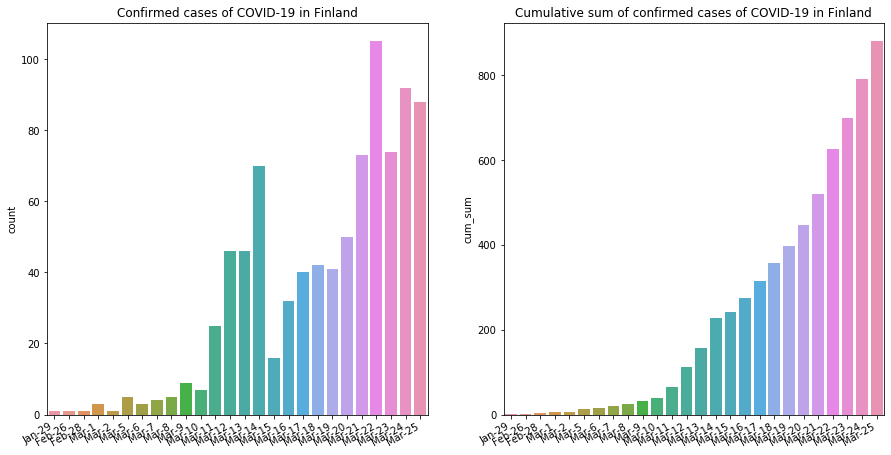

In [3]:
covid = dmc.extract_counts(df)

#covid['cum_sum'] = covid['count'].cumsum()
print(covid)
#print(covid.dtypes)

date_mapping = ["{}-{}".format(x.strftime("%b"),x.day) for x in covid['new_dates']]
#print(date_mapping)
fig,axes = plt.subplots(1,2,figsize=(15,8))
sns.barplot(x=date_mapping, y='count', data=covid,ax=axes[0])
sns.barplot(x=date_mapping, y='cum_sum', data=covid,ax=axes[1])
axes[0].title.set_text('Confirmed cases of COVID-19 in Finland')
axes[1].title.set_text('Cumulative sum of confirmed cases of COVID-19 in Finland')
fig.autofmt_xdate()



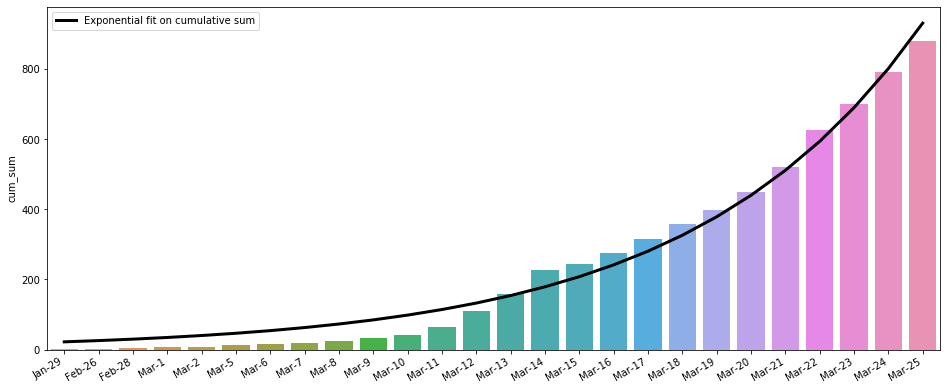

In [9]:
def exp_func(x, a, b, c):
    c = 0
    return a * np.exp(b * x) + c

date_mapping = ["{}-{}".format(x.strftime("%b"),x.day) for x in covid['new_dates']]
xdata = range(0,len(covid))
popt, pcov = curve_fit(exp_func, xdata, covid['cum_sum'])

fig,ax = plt.subplots(figsize=(16,7))
ax.plot(xdata, exp_func(xdata, *popt), 'k-',linewidth=3,label="Exponential fit on cumulative sum")
sns.barplot(x=date_mapping, y='cum_sum', data=covid,ax=ax)
fig.autofmt_xdate()
plt.legend()

Finland stopped testing people on a large scale, thus the data is inconclusive from now on (about 20.3.2020)

Read global data. (https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv)

In [5]:

df_global = dmc.get_data_global()
df_global.head()

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20,3/22/20,3/23/20,3/24/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0,0,0,0,0,0,0,0,0,...,16,21,22,22,22,24,24,40,40,74
Albania,0,0,0,0,0,0,0,0,0,0,...,42,51,55,59,64,70,76,89,104,123
Algeria,0,0,0,0,0,0,0,0,0,0,...,48,54,60,74,87,90,139,201,230,264
Andorra,0,0,0,0,0,0,0,0,0,0,...,1,2,39,39,53,75,88,113,133,164
Angola,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,2,2,3,3


Visualise the data for some countries/regions

1/22/20      548
1/23/20      643
1/24/20      920
1/25/20     1406
1/26/20     2075
           ...  
3/20/20    81250
3/21/20    81305
3/22/20    81435
3/23/20    81498
3/24/20    81591
Name: China, Length: 63, dtype: int64


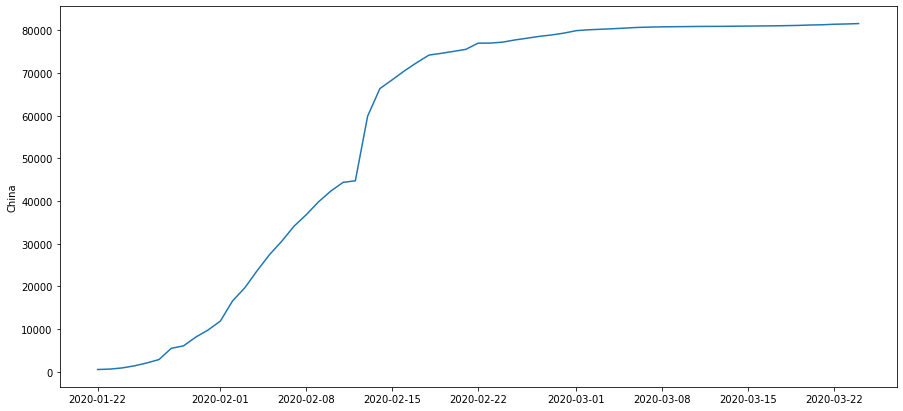

In [6]:
fig,ax = plt.subplots(figsize=(15,7))
sns.lineplot(pd.to_datetime(df_global.columns),df_global.loc["China"],ax=ax)
print(df_global.loc["China"])

Visualise the total confirmed cases (cumulative sum of all countries.)

In [7]:
df_global["group"] = pd.Series(np.ones(len(df_global)),index=df_global.index)
df_global_totals = df_global.groupby("group").sum()
global_total_timeseries = pd.Series(df_global_totals.values[0],index=pd.to_datetime(list(df_global_totals.columns)))
global_total_timeseries

2020-01-22       555
2020-01-23       654
2020-01-24       941
2020-01-25      1434
2020-01-26      2118
               ...  
2020-03-20    272164
2020-03-21    304519
2020-03-22    337089
2020-03-23    378547
2020-03-24    418678
Length: 63, dtype: int64

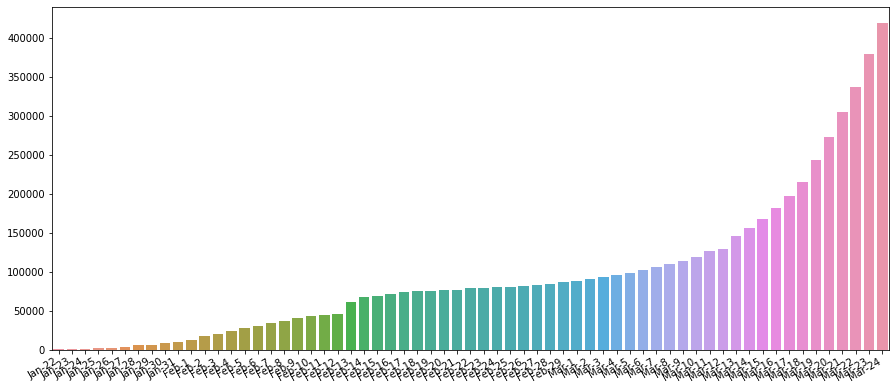

In [8]:
date_mapping = ["{}-{}".format(x.strftime("%b"),x.day) for x in global_total_timeseries.index]

fig2, ax2 = plt.subplots(figsize=(15,7))
sns.barplot(x=date_mapping,y=global_total_timeseries.values,ax=ax2)
fig2.autofmt_xdate()


Exponential model would not give good results heres, as there's clearly some dichotomous behaviour seen in the plot above.

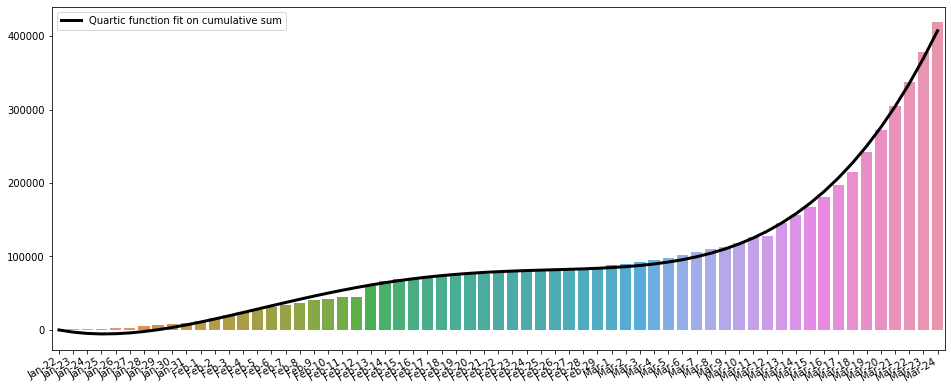

In [18]:
def quartic(x, a,b,c,d,e):
    e = 0
    # return a*x**3+b*x**2+c*x+d
    return a*x**4+b*x**3+c*x**2+d*x+e

date_mapping = ["{}-{}".format(x.strftime("%b"),x.day) for x in global_total_timeseries.index]
xdata = np.arange(0,len(global_total_timeseries))
popt, pcov = curve_fit(quartic, xdata, global_total_timeseries.values)

fig3,ax3 = plt.subplots(figsize=(16,7))
ax3.plot(xdata, quartic(xdata, *popt), 'k-',linewidth=3,label="Quartic function fit on cumulative sum")
sns.barplot(x=date_mapping,y=global_total_timeseries.values,ax=ax3)
fig3.autofmt_xdate()
plt.legend()

The Quartic function fit looks nice and probably has low error, but this could easily be a classical case of overfitting.